In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
tqdm.pandas()
from multiprocessing import Pool
import pickle
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import gc

c:\users\nanth\appdata\local\programs\python\python38\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
test_df = pd.read_csv('datasets/test.csv.gz', dtype={'ID': np.int32,
                                                    'shop_id': np.int32,
                                                    'item_id': np.int32})
test_df

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [3]:
item_df = pd.read_csv('datasets/items_with_tag.csv')
item_df

,Unnamed: 0,item_name,item_id,item_category_id,tag
0,0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,-1
1,1,!ABBYY FineReader 12 Professional Edition Full...,1,76,0
2,2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,-1
3,3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,-1
4,4,***КОРОБКА (СТЕКЛО) D,4,40,1
...,...,...,...,...,...
22165,22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,6
22166,22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,-1
22167,22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,-1
22168,22168,Яйцо для Little Inu,22168,62,547


In [4]:
sales_df = pd.read_csv('datasets/sales_train.csv.gz')
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%d.%m.%Y')
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [5]:
sales_df.isna().sum(axis=0)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

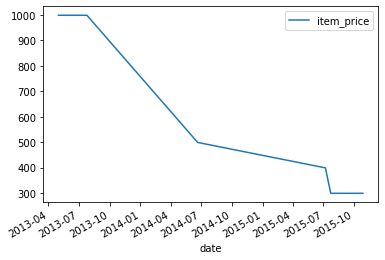

In [6]:
sample_item = sales_df.sample(1, random_state=123)
shop_id = sample_item['shop_id'].values[0]
item_id = sample_item['item_id'].values[0]
item_sales_df = sales_df[(sales_df['shop_id'] == shop_id) & (sales_df['item_id'] == item_id)].sort_values('date')
item_sales_df.plot(x='date', y='item_price')

In [7]:

def downcast_dataframe(df):
    dtype_mapper = {
        'int64': 'int16',
        'int32': 'int16',
        'float64': 'float16'
    }
    dtypes = df.dtypes.to_dict()

    new_dtypes = {col: dtype_mapper.get(str(dtype), str(dtype)) for col, dtype in dtypes.items()}
    return df.astype(new_dtypes)

In [8]:
monthly_sales_df = sales_df.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False) \
                            .agg({'item_price': 'mean', 'item_cnt_day': 'sum'})
monthly_sales_df.rename(columns={'item_cnt_day': 'count'}, inplace=True)
del sales_df, item_sales_df
gc.collect()
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count
0,0,30,1,265.0,31.0
1,0,31,1,434.0,11.0
2,0,32,0,221.0,6.0
3,0,32,1,221.0,10.0
4,0,33,0,347.0,3.0
...,...,...,...,...,...
1609119,59,22164,27,699.0,2.0
1609120,59,22164,30,699.0,1.0
1609121,59,22167,9,299.0,1.0
1609122,59,22167,11,299.0,2.0


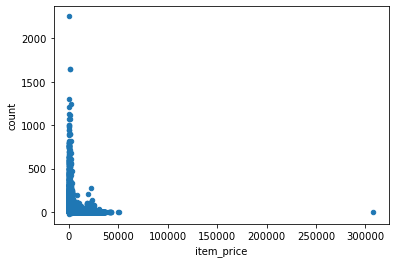

In [9]:

monthly_sales_df.plot.scatter(x='item_price', y='count')

In [10]:
monthly_sales_df = monthly_sales_df.merge(item_df[['item_id', 'item_category_id']], on='item_id')
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id
0,0,30,1,265.0,31.0,40
1,1,30,1,265.0,10.0,40
2,2,30,2,359.0,1.0,40
3,2,30,5,399.0,1.0,40
4,2,30,15,169.0,1.0,40
...,...,...,...,...,...,...
1609119,59,9760,12,179.0,1.0,37
1609120,59,12846,10,149.0,1.0,37
1609121,59,16270,6,1000.0,1.0,75
1609122,59,17732,9,198.0,1.0,28


In [11]:
monthly_sales_df.describe()

,shop_id,item_id,date_block_num,item_price,count,item_category_id
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,3.280585e+01,1.068099e+04,1.466479e+01,7.908847e+02,2.267200e+00,4.154192e+01
std,1.653701e+01,6.238883e+03,9.542322e+00,1.551605e+03,8.649882e+00,1.632365e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01,0.000000e+00
25%,2.100000e+01,5.045000e+03,6.000000e+00,1.990000e+02,1.000000e+00,3.000000e+01
50%,3.100000e+01,1.049700e+04,1.400000e+01,3.990000e+02,1.000000e+00,4.000000e+01
75%,4.700000e+01,1.606000e+04,2.300000e+01,8.985000e+02,2.000000e+00,5.500000e+01
max,5.900000e+01,2.216900e+04,3.300000e+01,3.079800e+05,2.253000e+03,8.300000e+01


### Prove the sales of any shop are different and unique

Text(0, 0.5, 'item_count')

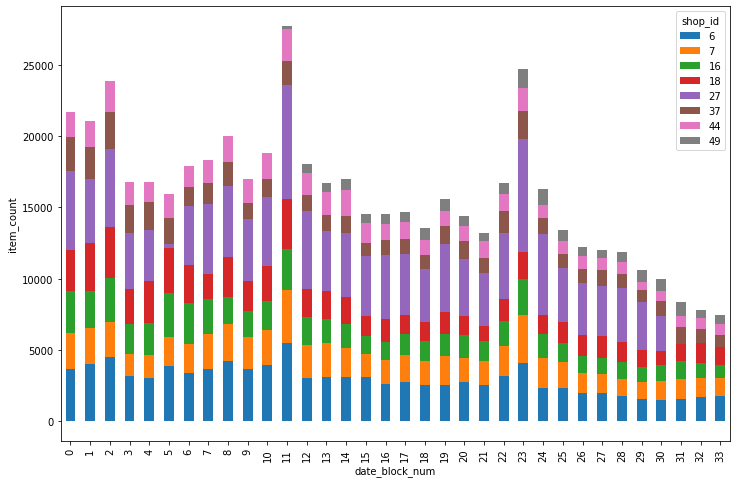

In [13]:
shop_ids = monthly_sales_df['shop_id']
selected_shop_ids = shop_ids.drop_duplicates().sample(8, random_state=99)

ax = monthly_sales_df[shop_ids.isin(selected_shop_ids)].groupby(['date_block_num', 'shop_id']).agg(
    {'count': 'sum'}).unstack().plot.bar(y='count', stacked=True, figsize=(12, 8))
ax.set_ylabel('item_count')

### Prove the sales of any item categories are different

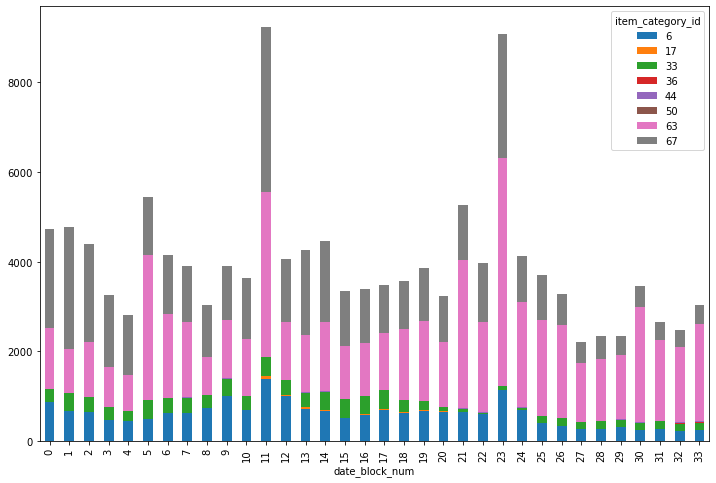

In [14]:
categories = monthly_sales_df['item_category_id']
selected_categories = categories.drop_duplicates().sample(8, random_state=1)
monthly_sales_df[categories.isin(selected_categories)].groupby(['date_block_num', 'item_category_id']).agg(
    {'count': 'sum'}).unstack().plot.bar(y='count', stacked=True, figsize=(12, 8))

### Distribution

In [15]:
def IQR(data, lower, upper):
    return data[(data > data.quantile(lower)) & (data < data.quantile(upper))]


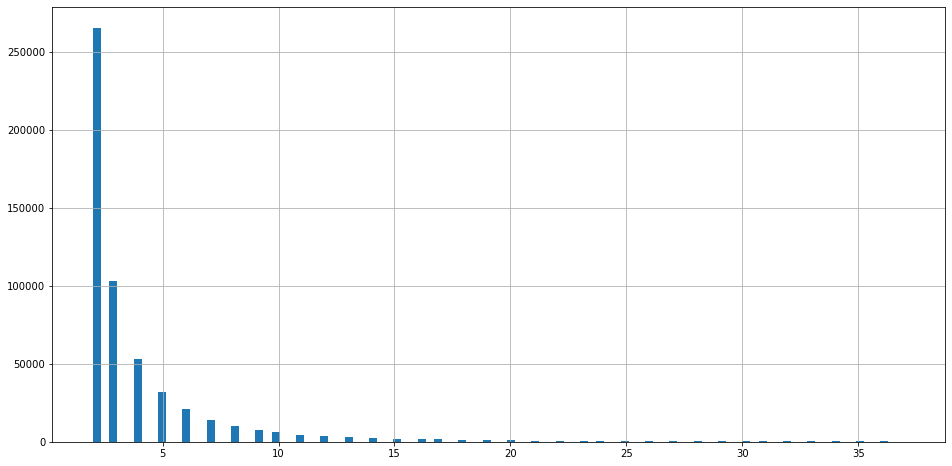

In [16]:
alpha = 0.0027
IQR(monthly_sales_df['count'], alpha, 1-alpha).hist(bins=100, figsize=(16, 8))

<AxesSubplot:>

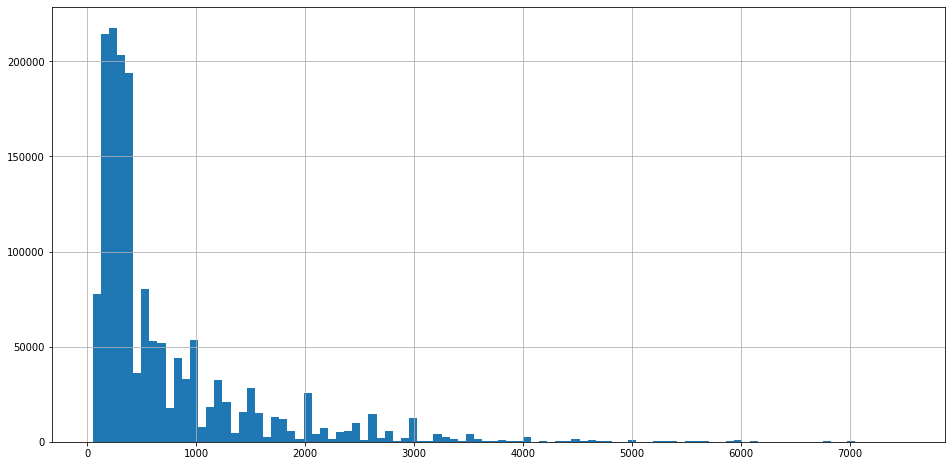

In [61]:
alpha = 0.008
IQR(monthly_sales_df['item_price'], alpha, 1-alpha).hist( bins=100, figsize=(16, 8))

In [62]:
monthly_sales_df.set_index(['shop_id', 'item_id', 'date_block_num']).head(20)

item_price  count  item_category_id
shop_id item_id date_block_num                                     
0       30      1                    265.0   31.0                40
1       30      1                    265.0   10.0                40
2       30      2                    359.0    1.0                40
                5                    399.0    1.0                40
                15                   169.0    1.0                40
                16                   169.0    1.0                40
3       30      1                    399.0    4.0                40
                2                    399.0    5.0                40
                3                    399.0    2.0                40
                4                    399.0    2.0                40
                5                    399.0    1.0                40
                9                    169.0    1.0                40
                10                   169.0    1.0                40
                11                   169.0    2.0                40
                12                   169.0    1.0                40
                30                   129.0    1.0                40
4       30      1                    399.0    7.0                40
                2                    399.0    3.0                40
                7                    399.0    1.0                40
5       30      1                    399.0    5.0                40

In [63]:
monthly_sales_df.nunique()

shop_id                60
item_id             21807
date_block_num         34
item_price          41464
count                 446
item_category_id       84
dtype: int64

In [64]:
test_df.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [65]:
gc.collect()

122

### Clip count

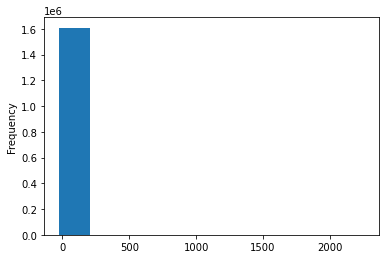

In [12]:
monthly_sales_df['count'].plot.hist()

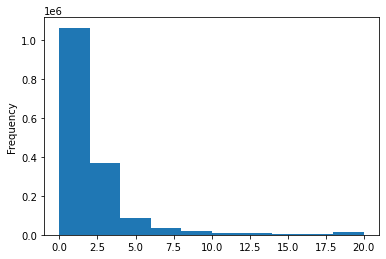

In [13]:
monthly_sales_df['count'].clip(0, 20, inplace=True)
# monthly_sales_df['count'].clip(0, 100, inplace=True)
monthly_sales_df['count'].plot.hist()

### Create monthly_sales_df backup 

In [14]:
_monthly_sales_df = monthly_sales_df.copy()

In [15]:
_monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id
0,0,30,1,265.0,20.0,40
1,1,30,1,265.0,10.0,40
2,2,30,2,359.0,1.0,40
3,2,30,5,399.0,1.0,40
4,2,30,15,169.0,1.0,40
...,...,...,...,...,...,...
1609119,59,9760,12,179.0,1.0,37
1609120,59,12846,10,149.0,1.0,37
1609121,59,16270,6,1000.0,1.0,75
1609122,59,17732,9,198.0,1.0,28


## Feature Engineering

### Generate Grid features


In [16]:
from itertools import product

In [43]:
monthly_sales_df = _monthly_sales_df.copy()
grid = []

unique_shops = test_df['shop_id'].unique()
unique_items = test_df['item_id'].unique()

# unique_shops = pd.concat((test_df['shop_id'], monthly_sales_df['shop_id'])).unique()
# unique_items = pd.concat((test_df['item_id'], monthly_sales_df['item_id'])).unique()

unique_block_nums = monthly_sales_df['date_block_num'].unique()

grid.append(np.array(list(product(*[unique_shops, unique_items, unique_block_nums])),dtype='int32'))
# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns=['shop_id', 'item_id', 'date_block_num'],dtype=np.int32)
data = grid.merge(monthly_sales_df, how='left', on=['shop_id', 'item_id', 'date_block_num'])
# data.fillna(fillna_series, inplace=True)
del grid, monthly_sales_df
gc.collect()

144

In [26]:
monthly_sales_df = _monthly_sales_df.copy()
grid = []
for block_num in monthly_sales_df['date_block_num'].unique():
    cur_shops = monthly_sales_df[monthly_sales_df['date_block_num']==block_num]['shop_id'].unique()
    cur_items = monthly_sales_df[monthly_sales_df['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns=['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)
data = grid.merge(monthly_sales_df, how='left', on=['shop_id', 'item_id', 'date_block_num'])
del grid, monthly_sales_df
gc.collect()

0

In [44]:
# Fill item price
def fill_nan_by_date_block( df):
#     df['item_price'] = df['item_price'].ffill().bfill().fillna(0)
    df['item_price'] = df['item_price'].mean()
    df['item_price'].fillna(0, inplace=True)
    return df
data = data.sort_values('date_block_num')
data = data.groupby(['shop_id', 'item_id'], as_index=False).progress_apply(lambda group: fill_nan_by_date_block(group))

data.fillna({'count': 0, 'item_category_id': data['item_category_id'].max()+1}, inplace=True)


100%|████████████████████████████████████████████████████████████████████████| 214200/214200 [01:37<00:00, 2196.34it/s]


In [45]:
data = downcast_dataframe(data)

### Item name clustering

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering, DBSCAN

from scipy.cluster.hierarchy import dendrogram

In [47]:
pre_assign_tag = True
if not pre_assign_tag:
    vectorizer = CountVectorizer()
    bow = vectorizer.fit_transform(item_df['item_name'])
    bow[bow.sum(axis=1)==0] = 99
    X = bow.toarray()

    clustering = DBSCAN(eps=2, metric='l1', min_samples=2, n_jobs=8)
    clustering.fit(X)

    item_df['tag'] = clustering.labels_
    clustered_df = item_df.groupby('tag').agg(children=('item_name', lambda names: '\n'.join(names)), count=('item_name', 'count'))
    clustered_df.sort_values('count', ascending=False).head(20)

In [48]:
data = data.merge(item_df[['item_id', 'tag']], how='left', on='item_id')

In [49]:

data.head()

,shop_id,item_id,date_block_num,item_price,count,item_category_id,tag
0,42,969,0,491.50,0.0,84.0,105
1,21,9894,0,349.00,0.0,84.0,-1
2,21,8391,0,432.25,0.0,84.0,989
3,21,9425,0,349.00,0.0,84.0,-1
4,21,3344,0,2124.00,0.0,84.0,402


### Deal with out-of-test item id

In [50]:
test_item_ids = test_df['item_id']
out_of_test_item_ids = test_item_ids[~test_item_ids.isin(_monthly_sales_df['item_id'])].drop_duplicates()
out_of_test_df = data[data['item_id'].isin(out_of_test_item_ids)]
in_the_test_item_ids = test_item_ids[test_item_ids.isin(_monthly_sales_df['item_id'])].drop_duplicates()

In [51]:

# data.loc[data['item_id'].isin(out_of_test_item_ids), 'count'] = data.loc[data['item_id'].isin(in_the_test_item_ids), 'count'].mean()

data.loc[data['item_id'].isin(out_of_test_item_ids), 'count'] = 0


In [52]:
data.loc[data['item_id'].isin(out_of_test_item_ids),].head()

,shop_id,item_id,date_block_num,item_price,count,item_category_id,tag
21,21,15418,0,0.0,0.0,84.0,1642
36,21,20196,0,0.0,0.0,84.0,-1
41,21,19651,0,0.0,0.0,84.0,6
68,21,1679,0,0.0,0.0,84.0,-1
92,21,13446,0,0.0,0.0,84.0,-1


### Backup data

In [53]:
_data = data.copy()
_data.head()

,shop_id,item_id,date_block_num,item_price,count,item_category_id,tag
0,42,969,0,491.50,0.0,84.0,105
1,21,9894,0,349.00,0.0,84.0,-1
2,21,8391,0,432.25,0.0,84.0,989
3,21,9425,0,349.00,0.0,84.0,-1
4,21,3344,0,2124.00,0.0,84.0,402


### Create date block feature

In [54]:
def generate_feature(df, by, base_col, output_col, agg_func):
    agg_df = df.groupby(by, as_index=False).agg({base_col: agg_func})
    agg_df.rename(columns={base_col: output_col}, inplace=True)
    return df.merge(agg_df, how='left', on=by)

In [55]:
data = _data.copy()
data = generate_feature(data, by=[
    'item_id', 'date_block_num'], base_col='count', output_col='count_by_item', agg_func='sum')
data = generate_feature(data, by=[
    'item_category_id', 'date_block_num'], base_col='count', output_col='count_by_item_cat', agg_func='sum')
data = generate_feature(data, by=[
    'tag', 'date_block_num'], base_col='count', output_col='count_by_tag', agg_func='sum')

data = generate_feature(data, by=[
    'shop_id', 'date_block_num'], base_col='count', output_col='count_avg_by_shop', agg_func='mean')
data = generate_feature(data, by=[
    'item_id', 'date_block_num'], base_col='count', output_col='count_avg_by_item', agg_func='mean')
data = generate_feature(data, by=[
    'item_category_id', 'date_block_num'], base_col='count', output_col='count_avg_by_item_cat', agg_func='mean')
data = generate_feature(data, by=[
    'tag', 'date_block_num'], base_col='count', output_col='count_avg_by_tag', agg_func='mean')

data = generate_feature(data, by=[
    'shop_id', 'date_block_num'], base_col='item_price', output_col='avg_shop_price', agg_func='mean')
data = generate_feature(data, by=[
    'item_id', 'date_block_num'], base_col='item_price', output_col='avg_item_price', agg_func='mean')
data = generate_feature(data, by=[
    'item_category_id', 'date_block_num'], base_col='item_price', output_col='avg_item_cat_price', agg_func='mean')

data

,shop_id,item_id,date_block_num,item_price,count,item_category_id,tag,count_by_item,count_by_item_cat,count_by_tag,count_avg_by_shop,count_avg_by_item,count_avg_by_item_cat,count_avg_by_tag,avg_shop_price,avg_item_price,avg_item_cat_price
0,42,969,0,491.50,0.0,84.0,105,0.0,0.0,0.0,0.169434,0.000000,0.0,0.000000,723.00,420.000000,512.50
1,21,9894,0,349.00,0.0,84.0,-1,0.0,0.0,9048.0,0.065674,0.000000,0.0,0.090942,634.50,266.000000,512.50
2,21,8391,0,432.25,0.0,84.0,989,0.0,0.0,0.0,0.065674,0.000000,0.0,0.000000,634.50,338.500000,512.50
3,21,9425,0,349.00,0.0,84.0,-1,0.0,0.0,9048.0,0.065674,0.000000,0.0,0.090942,634.50,24.921875,512.50
4,21,3344,0,2124.00,0.0,84.0,402,0.0,0.0,131.0,0.065674,0.000000,0.0,0.520020,634.50,2048.000000,512.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282795,10,11575,33,86.50,0.0,84.0,6,22.0,0.0,10552.0,0.081787,0.523926,0.0,0.277832,305.00,133.125000,410.25
7282796,38,11113,33,0.00,0.0,84.0,1236,6.0,0.0,6.0,0.199463,0.142822,0.0,0.142822,538.00,177.125000,410.25
7282797,39,7541,33,0.00,0.0,84.0,-1,1.0,0.0,21360.0,0.162109,0.023804,0.0,0.214600,478.25,16.640625,410.25
7282798,31,15374,33,316.75,0.0,84.0,-1,0.0,0.0,21360.0,0.984863,0.000000,0.0,0.214600,771.50,258.500000,410.25


### Create revenue feature

In [56]:
data['revenue'] = data['item_price'] * data['count']

### Create month feature

In [57]:
data['month'] = data['date_block_num'] % 12

In [58]:
# data = generate_feature(data, by=[
#     'item_id', 'date_block_num'], base_col='count', output_col='count_by_item', agg_func='sum')
# data = generate_feature(data, by=[
#     'item_category_id', 'date_block_num'], base_col='count', output_col='count_by_item_cat', agg_func='sum')
# data = generate_feature(data, by=[
#     'tag', 'date_block_num'], base_col='count', output_col='count_by_tag', agg_func='sum')

data = generate_feature(data, by=[
    'shop_id', 'month'], base_col='count', output_col='monthly_count_avg_by_shop', agg_func='mean')
data = generate_feature(data, by=[
    'item_id', 'month'], base_col='count', output_col='monthly_count_avg_by_item', agg_func='mean')
data = generate_feature(data, by=[
    'item_category_id', 'month'], base_col='count', output_col='monthly_count_avg_by_item_cat', agg_func='mean')
data = generate_feature(data, by=[
    'tag', 'month'], base_col='count', output_col='monthly_count_avg_by_tag', agg_func='mean')

# data = generate_feature(data, by=[
#     'shop_id', 'date_block_num'], base_col='item_price', output_col='avg_shop_price', agg_func='mean')
# data = generate_feature(data, by=[
#     'item_id', 'date_block_num'], base_col='item_price', output_col='avg_item_price', agg_func='mean')
# data = generate_feature(data, by=[
#     'item_category_id', 'date_block_num'], base_col='item_price', output_col='avg_item_cat_price', agg_func='mean')

In [59]:
data

,shop_id,item_id,date_block_num,item_price,count,item_category_id,tag,count_by_item,count_by_item_cat,count_by_tag,...,count_avg_by_tag,avg_shop_price,avg_item_price,avg_item_cat_price,revenue,month,monthly_count_avg_by_shop,monthly_count_avg_by_item,monthly_count_avg_by_item_cat,monthly_count_avg_by_tag
0,42,969,0,491.50,0.0,84.0,105,0.0,0.0,0.0,...,0.000000,723.00,420.000000,512.50,0.0,0,0.316406,0.047607,0.0,0.059509
1,21,9894,0,349.00,0.0,84.0,-1,0.0,0.0,9048.0,...,0.090942,634.50,266.000000,512.50,0.0,0,0.153564,0.000000,0.0,0.166870
2,21,8391,0,432.25,0.0,84.0,989,0.0,0.0,0.0,...,0.000000,634.50,338.500000,512.50,0.0,0,0.153564,0.000000,0.0,0.000000
3,21,9425,0,349.00,0.0,84.0,-1,0.0,0.0,9048.0,...,0.090942,634.50,24.921875,512.50,0.0,0,0.153564,0.000000,0.0,0.166870
4,21,3344,0,2124.00,0.0,84.0,402,0.0,0.0,131.0,...,0.520020,634.50,2048.000000,512.50,0.0,0,0.153564,0.388916,0.0,1.007812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282795,10,11575,33,86.50,0.0,84.0,6,22.0,0.0,10552.0,...,0.277832,305.00,133.125000,410.25,0.0,9,0.081909,0.380859,0.0,0.216064
7282796,38,11113,33,0.00,0.0,84.0,1236,6.0,0.0,6.0,...,0.142822,538.00,177.125000,410.25,0.0,9,0.160034,0.047607,0.0,0.047607
7282797,39,7541,33,0.00,0.0,84.0,-1,1.0,0.0,21360.0,...,0.214600,478.25,16.640625,410.25,0.0,9,0.081055,0.023804,0.0,0.170898
7282798,31,15374,33,316.75,0.0,84.0,-1,0.0,0.0,21360.0,...,0.214600,771.50,258.500000,410.25,0.0,9,0.773438,0.063477,0.0,0.170898


### Mean Encoding

In [60]:
def mean_encoding(df, cat_col, target_col):
    encoder = df.groupby(cat_col)[target_col].mean()
    return df[cat_col].map(encoder)
data['shop_id_encoded'] = mean_encoding(data, 'shop_id', 'count')
data['item_id_encoded'] = mean_encoding(data, 'item_id', 'count')
data['item_category_id_encoded'] = mean_encoding(data, 'item_category_id', 'count')
data['month_encoded'] = mean_encoding(data, 'month', 'count')
data['tag_encoded'] = mean_encoding(data, 'tag', 'count')
data

,shop_id,item_id,date_block_num,item_price,count,item_category_id,tag,count_by_item,count_by_item_cat,count_by_tag,...,month,monthly_count_avg_by_shop,monthly_count_avg_by_item,monthly_count_avg_by_item_cat,monthly_count_avg_by_tag,shop_id_encoded,item_id_encoded,item_category_id_encoded,month_encoded,tag_encoded
0,42,969,0,491.50,0.0,84.0,105,0.0,0.0,0.0,...,0,0.316406,0.047607,0.0,0.059509,0.368896,0.158203,0.0,0.177734,0.258057
1,21,9894,0,349.00,0.0,84.0,-1,0.0,0.0,9048.0,...,0,0.153564,0.000000,0.0,0.166870,0.193359,0.054626,0.0,0.177734,0.170532
2,21,8391,0,432.25,0.0,84.0,989,0.0,0.0,0.0,...,0,0.153564,0.000000,0.0,0.000000,0.193359,0.158203,0.0,0.177734,0.158203
3,21,9425,0,349.00,0.0,84.0,-1,0.0,0.0,9048.0,...,0,0.153564,0.000000,0.0,0.166870,0.193359,0.002100,0.0,0.177734,0.170532
4,21,3344,0,2124.00,0.0,84.0,402,0.0,0.0,131.0,...,0,0.153564,0.388916,0.0,1.007812,0.193359,0.240845,0.0,0.177734,1.151367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282795,10,11575,33,86.50,0.0,84.0,6,22.0,0.0,10552.0,...,9,0.081909,0.380859,0.0,0.216064,0.071045,0.317139,0.0,0.201538,0.193726
7282796,38,11113,33,0.00,0.0,84.0,1236,6.0,0.0,6.0,...,9,0.160034,0.047607,0.0,0.047607,0.168457,0.061615,0.0,0.201538,0.061615
7282797,39,7541,33,0.00,0.0,84.0,-1,1.0,0.0,21360.0,...,9,0.081055,0.023804,0.0,0.170898,0.062286,0.028015,0.0,0.201538,0.170532
7282798,31,15374,33,316.75,0.0,84.0,-1,0.0,0.0,21360.0,...,9,0.773438,0.063477,0.0,0.170898,0.715332,0.115540,0.0,0.201538,0.170532


### Define categorical columns

In [61]:
category_cols = ['shop_id', 'item_id', 'date_block_num', 'item_category_id', 'month', 'tag']

### Generate past-features

In [62]:
timeserie_cols = [
    'count', 'revenue',
    'count_by_item', 'count_by_item_cat', 'count_by_tag',
    'count_avg_by_shop', 'count_avg_by_item', 'count_avg_by_item_cat', 'count_avg_by_tag',
    'monthly_count_avg_by_shop', 'monthly_count_avg_by_item', 'monthly_count_avg_by_item_cat', 'monthly_count_avg_by_tag',
    'avg_shop_price', 'avg_item_price', 'avg_item_cat_price'
] 

In [63]:

def generate_past_features(data, lookback_steps):
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    new_data = data[data['date_block_num'] >= max(lookback_steps)+data['date_block_num'].min()]

    for lookback_num in tqdm(lookback_steps):
        month_shift_df = data.copy()
        month_shift_df['date_block_num'] = month_shift_df['date_block_num'] + lookback_num

        lookback_cols = [f'p{lookback_num}_{col}' for col in timeserie_cols]
        month_shift_df.rename(columns={old_col: new_col for old_col, new_col in zip(timeserie_cols, lookback_cols)}, inplace=True)
        month_shift_df = month_shift_df[month_shift_df.columns.sort_values()]
        new_data = new_data.merge(
            month_shift_df[index_cols+lookback_cols], how='left', on=index_cols)
    return new_data

### Cross validation split

In [64]:

lookback_steps = np.array([1, 2, 3, 4, 5])
train_data = generate_past_features(data, lookback_steps)
target_col = 'count'
feature_cols = train_data.columns.difference(
    [target_col, 'date_block_num', 'item_price', 'revenue',
     'count_by_shop', 'count_by_item', 'count_by_item_cat', 'count_by_tag',
     'count_avg_by_shop', 'count_avg_by_item', 'count_avg_by_item_cat', 'count_avg_by_tag',
    'monthly_count_avg_by_shop', 'monthly_count_avg_by_item', 'monthly_count_avg_by_item_cat', 'monthly_count_avg_by_tag',
     'avg_shop_price', 'avg_item_price', 'avg_item_cat_price', 'avg_tag_price',
#      'shop_id', 'item_id', 'item_category_id', 'month', 'tag', 
#      'shop_id_encoded', 'item_id_encoded', 'item_category_id_encoded', 'month_encoded'
    ]).sort_values().to_list()

# train_data[target_col] = train_data[target_col].clip(inverse_scaling(0, 'count'), inverse_scaling(20, 'count'))
train_data[target_col] = train_data[target_col].clip(0, 20)

X = train_data[feature_cols]
Y = train_data[target_col]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.67s/it]


In [65]:
# val_blocks = [29, 30, 31, 32, 33]
train_blocks = np.arange(33)
val_blocks = [33]

# train_indice = (train_data['date_block_num'] >= 0) & (train_data['date_block_num'] < min(val_blocks))
train_indice = train_data['date_block_num'].isin(train_blocks)
val_indice = train_data['date_block_num'].isin(val_blocks)
monthly_indice = train_data['shop_id'].isin(_monthly_sales_df['shop_id'].drop_duplicates()) & train_data['item_id'].isin(_monthly_sales_df['item_id'].drop_duplicates())

X_train = train_data.loc[train_indice & monthly_indice, feature_cols]
Y_train = train_data.loc[train_indice & monthly_indice, target_col]

X_val = train_data.loc[val_indice & monthly_indice, feature_cols]
Y_val = train_data.loc[val_indice & monthly_indice, target_col]

In [66]:
K = 5

fold_size = (train_data['date_block_num'].max() - train_data['date_block_num'].min()) // K

train_indices = []
val_indicies = []

start_date_num = train_data['date_block_num'].min()
for i in range(1, K+1):
    train_indice = np.where(train_data['date_block_num'] < start_date_num + i*fold_size)[0]
    print('fold', i, 'train', train_data.iloc[train_indice]['date_block_num'].unique())
    val_indice = np.where(train_data['date_block_num'].isin(start_date_num + np.arange(i*fold_size, (i+1)*fold_size)))[0]
    print('fold', i, 'val', train_data.iloc[val_indice]['date_block_num'].unique())
    
    train_indices.append(train_indice)
    val_indicies.append(val_indice)
Kfold = list(zip(train_indices, val_indicies))

fold 1 train [5 6 7 8 9]
fold 1 val [10 11 12 13 14]
fold 2 train [ 5  6  7  8  9 10 11 12 13 14]
fold 2 val [15 16 17 18 19]
fold 3 train [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
fold 3 val [20 21 22 23 24]
fold 4 train [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
fold 4 val [25 26 27 28 29]
fold 5 train [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29]
fold 5 val [30 31 32 33]


In [67]:
del train_data
gc.collect()

100

In [68]:
test_lookback_steps = lookback_steps - 1

test_block = data['date_block_num'].max()
test_data = data[data['date_block_num'] >= test_block - max(test_lookback_steps)]
test_data = generate_past_features(test_data, test_lookback_steps)
test_data = test_data[test_data['date_block_num'] == test_block]
test_data = test_df.merge(test_data, how='left', on=['shop_id', 'item_id'])


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


In [69]:
feature_cols = test_data.columns.difference(
    [target_col, 'ID', 'date_block_num', 'item_price', 'revenue',
     'count_by_shop', 'count_by_item', 'count_by_item_cat', 'count_by_tag',
     'count_avg_by_shop', 'count_avg_by_item', 'count_avg_by_item_cat', 'count_avg_by_tag',
    'monthly_count_avg_by_shop', 'monthly_count_avg_by_item', 'monthly_count_avg_by_item_cat', 'monthly_count_avg_by_tag',
     'avg_shop_price', 'avg_item_price', 'avg_item_cat_price', 'avg_tag_price',
#      'shop_id', 'item_id', 'item_category_id', 'month', 'tag',
#      'shop_id_encoded', 'item_id_encoded', 'item_category_id_encoded', 'month_encoded'
    ]).sort_values().to_list()
X_test = test_data[feature_cols]

# del test_data
gc.collect()
X_test

,item_category_id,item_category_id_encoded,item_id,item_id_encoded,month,month_encoded,p0_avg_item_cat_price,p0_avg_item_price,p0_avg_shop_price,p0_count,...,p4_count_by_tag,p4_monthly_count_avg_by_item,p4_monthly_count_avg_by_item_cat,p4_monthly_count_avg_by_shop,p4_monthly_count_avg_by_tag,p4_revenue,shop_id,shop_id_encoded,tag,tag_encoded
0,84.0,0.000000,5037,0.795410,9,0.201538,410.25,1822.0000,479.75,0.0,...,240.0,0.753906,2.398438,0.122314,0.630859,1694.0,5,0.130859,634,0.873535
1,84.0,0.000000,5320,0.000000,9,0.201538,410.25,0.0000,479.75,0.0,...,18080.0,0.000000,0.000000,0.122314,0.154663,0.0,5,0.130859,-1,0.170532
2,19.0,2.699219,5233,0.341797,9,0.201538,1641.00,816.5000,479.75,1.0,...,180.0,0.856934,2.398438,0.122314,0.595215,1718.0,5,0.130859,650,0.656738
3,84.0,0.000000,5232,0.098022,9,0.201538,410.25,704.5000,479.75,0.0,...,0.0,0.000000,0.000000,0.122314,0.000000,0.0,5,0.130859,652,0.049011
4,84.0,0.000000,5268,0.000000,9,0.201538,410.25,0.0000,479.75,0.0,...,18080.0,0.000000,0.000000,0.122314,0.154663,0.0,5,0.130859,-1,0.170532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,55.0,1.487305,18454,0.321533,9,0.201538,315.75,159.5000,462.50,1.0,...,127.0,0.142822,0.000000,0.110779,0.346680,0.0,45,0.116394,1920,0.248657
214196,84.0,0.000000,16188,0.002802,9,0.201538,410.25,119.6875,462.50,0.0,...,0.0,0.000000,0.000000,0.110779,0.000000,0.0,45,0.116394,1710,0.007004
214197,84.0,0.000000,15757,0.209351,9,0.201538,410.25,176.2500,462.50,0.0,...,8.0,0.230103,0.000000,0.110779,0.230103,0.0,45,0.116394,1464,0.209351
214198,84.0,0.000000,19648,0.034302,9,0.201538,410.25,37.5625,462.50,0.0,...,18080.0,0.031738,0.000000,0.110779,0.154663,0.0,45,0.116394,-1,0.170532


In [123]:
del data
gc.collect()

40

## Model Building

In [70]:
from sklearn.model_selection import cross_validate

In [71]:
metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
scoring = {'rmse': make_scorer(metrics['rmse'], greater_is_better=False),
           'r2': make_scorer(metrics['r2'], greater_is_better=True)
          }
def evaluate(y_true, y_pred, inverse_normalize=True):
    if inverse_normalize:
        y_true = inverse_scaling(y_true, 'count')
        y_pred = inverse_scaling(y_pred, 'count')
    return {name: metric(y_true, y_pred) for name, metric in metrics.items()}
def plot_feature_importance(feature_importances, columns):
    return pd.Series(feature_importances, index=columns).plot.bar(figsize=(16, 8))

### Random Forest

In [48]:
from sklearn.ensemble import RandomForestRegressor

In [56]:
rfr = RandomForestRegressor(n_estimators=100,
                            max_depth=16,
                            max_features='sqrt',
                            min_samples_split=2,
                            verbose=100,
                            random_state=42,
                            n_jobs=-1)
rfr.fit(X_train, Y_train,
        )

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.8s

building tree 14 of 100[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.7s

building tree 15 of 100[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   26.0s

building tree 16 of 100[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   27.0s

building tree 17 of 100[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   28.0s

building tree 18 of 100[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   34.2s

building tree 19 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   35.7s

building tree 20 of 100[Parallel(n_jo

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=100, warm_start=False)

In [57]:
prediction = rfr.predict(X_val)

result = pd.Series(evaluate(Y_val, prediction, inverse_normalize=True))
result

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  15 tasks      | elaps

rmse    0.953604
r2      0.680656
dtype: float64

In [332]:
prediction = rfr.predict(X_val)

result = pd.Series(evaluate(Y_val, prediction, inverse_normalize=True))
result

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.1s
[Para

rmse    0.626516
r2      0.669533
dtype: float64

In [177]:
prediction = rfr.predict(X_val)

result = pd.Series(evaluate(Y_val, prediction))
result

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.1s
[Para

rmse    0.620860
r2      0.675473
dtype: float64

<AxesSubplot:>

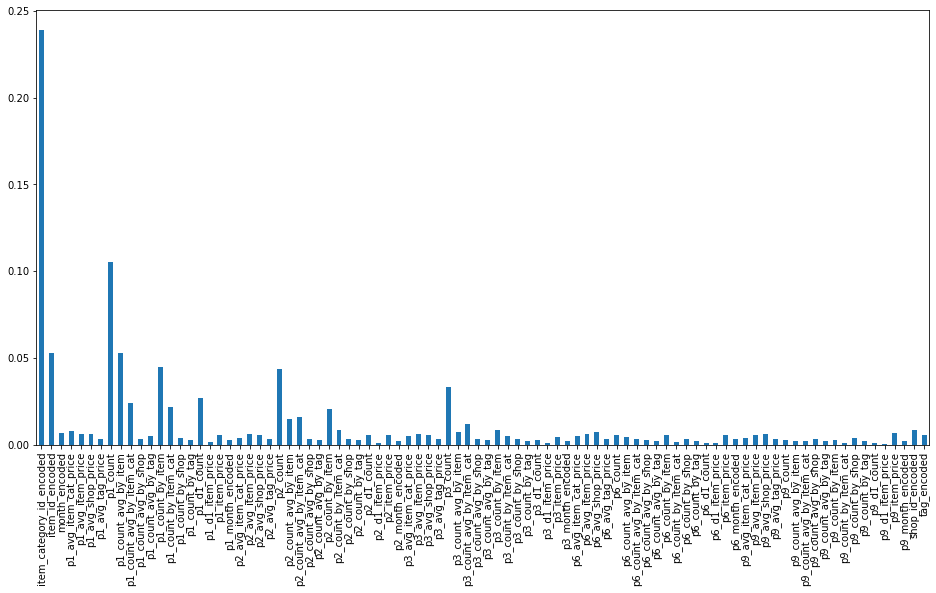

In [281]:

plot_feature_importance(rfr.feature_importances_, X_train.columns)

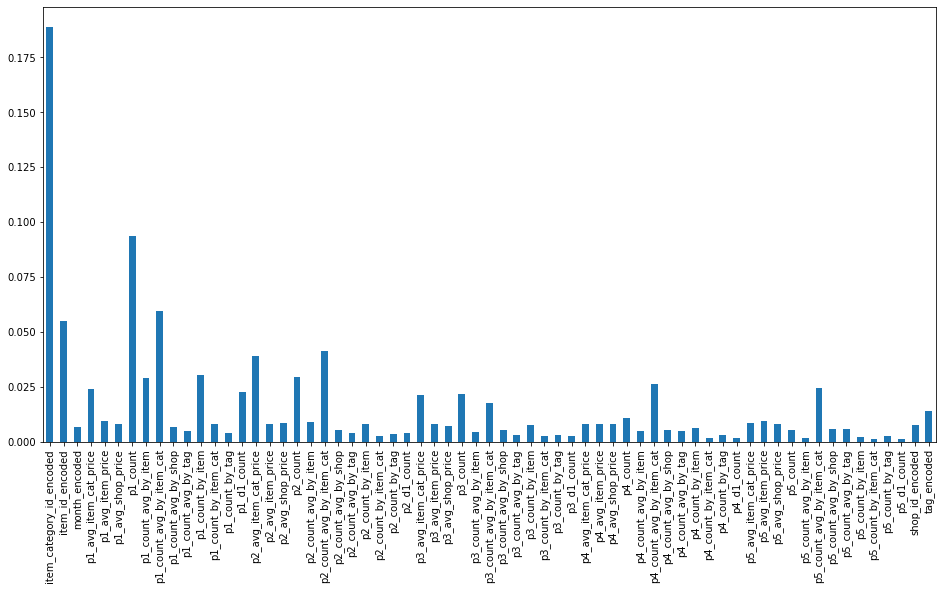

In [58]:

plot_feature_importance(rfr.feature_importances_, X_train.columns)

In [92]:
rfr = RandomForestRegressor(n_estimators=100,
                            max_depth=16,
                            max_features='sqrt',
                            min_samples_split=2,
                            verbose=100,
                            random_state=42,)


In [209]:
results = cross_validate(rfr, X, Y, cv=Kfold, scoring=scoring, n_jobs=4, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.7min remaining: 17.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.6min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.6min remaining:    0.0s


KeyboardInterrupt: 

In [100]:
pd.DataFrame(scores)

,rmse,r2
0,0.686071,0.642683
1,0.540569,0.707159
2,0.695557,0.709193
3,0.593505,0.677166
4,0.582306,0.691719


### Random forest hyperparam search

In [154]:
from sklearn.model_selection import RandomizedSearchCV

In [157]:
param_space = {
    'n_estimators': [32, 50, 100, 200, 500],
    'max_depth': [16, 50, 100, 200, 500],
    'max_features': ['sqrt', 0.2, 0.5, 1],
    'min_samples_split': [2, 100, 1000, ],
    'max_samples': [1, 0.5, 0.2, 1/32]
    
}

rs = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                        param_distributions=param_space,
                        verbose=10,
                        cv=2,
                        n_iter=20,
                        random_state= 101,
                       n_jobs=-1)
rs.fit(X_train, Y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed: 10.0min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed: 13.9min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed: 17.5min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed: 26.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 31.3min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [161]:
pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_samples,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
16,806.843132,15.826852,13.982409,2.281501,100,2,0.5,0.5,16,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.744811,0.716152,0.730482,0.014329,1
1,683.165437,25.975372,113.086752,10.637078,200,2,0.2,sqrt,200,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.725273,0.699259,0.712266,0.013007,2
19,935.684581,25.248265,59.881281,7.285805,500,100,0.2,0.2,16,"{'n_estimators': 500, 'min_samples_split': 100...",0.726455,0.697856,0.712155,0.014299,3
0,1222.029005,51.409223,53.722193,2.687793,200,100,0.5,sqrt,500,"{'n_estimators': 200, 'min_samples_split': 100...",0.708576,0.696385,0.702480,0.006096,4
8,1526.964338,32.744299,16.401848,2.107711,200,1000,0.5,0.5,200,"{'n_estimators': 200, 'min_samples_split': 100...",0.717510,0.685622,0.701566,0.015944,5
10,89.413093,2.205078,18.424968,2.221946,100,100,0.03125,0.5,16,"{'n_estimators': 100, 'min_samples_split': 100...",0.716219,0.682213,0.699216,0.017003,6
15,360.526446,36.563944,25.972757,4.428227,50,2,0.5,sqrt,50,"{'n_estimators': 50, 'min_samples_split': 2, '...",0.723778,0.673631,0.698705,0.025074,7
11,143.395227,2.414826,5.597195,0.189515,32,1000,0.2,0.5,100,"{'n_estimators': 32, 'min_samples_split': 1000...",0.702689,0.663473,0.683081,0.019608,8
14,210.065117,1.784000,8.534146,0.787572,32,1000,0.5,0.2,200,"{'n_estimators': 32, 'min_samples_split': 1000...",0.701340,0.661766,0.681553,0.019787,9
18,29.495528,1.416485,15.190345,0.875552,50,100,0.03125,sqrt,50,"{'n_estimators': 50, 'min_samples_split': 100,...",0.647065,0.640476,0.643770,0.003294,10


In [164]:
rfr = RandomForestRegressor(n_estimators=100,
                            min_samples_split=2,
                            max_samples=0.5,
                            max_features=0.5,
                            max_depth=16,
                            n_jobs=4,
                            verbose=10
                           )
rfr.fit(X_train, Y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   23.3s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   37.7s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   54.3s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.2min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.6min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.6min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  3.1min


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  3.7min


building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  4.2min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  4.7min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=0.5, max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=None, verbose=10, warm_start=False)

In [165]:
prediction = rfr.predict(X_val)
prediction = inverse_scaling(prediction, 'count')

metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
result = pd.Series({name: metric(inverse_scaling(Y_val, 'count'), prediction) for name, metric in metrics.items()})
result

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


rmse    0.61078
r2      0.70037
dtype: float64

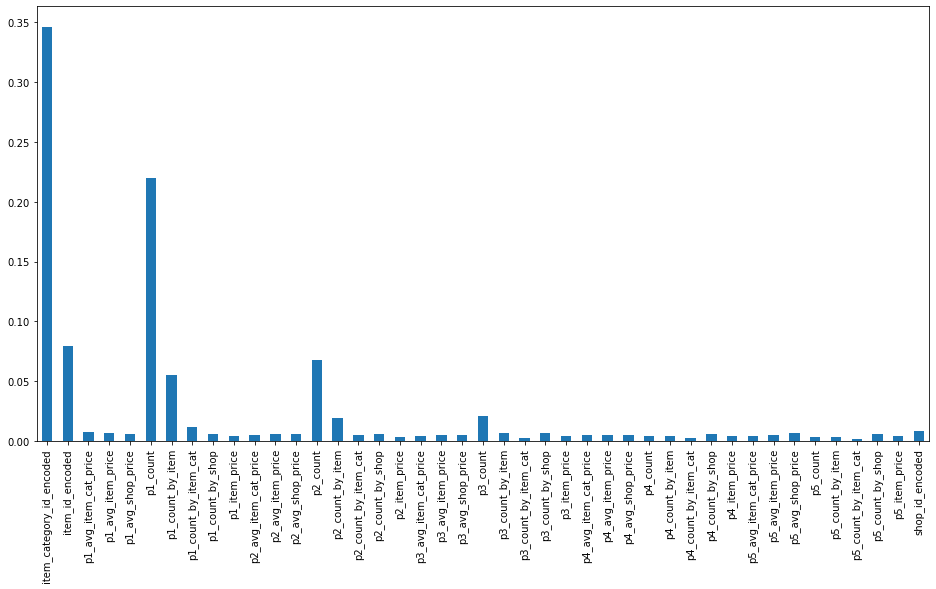

In [166]:

pd.Series(rfr.feature_importances_, index=X_train.columns).plot.bar(figsize=(16, 8))

### LightGBM

In [72]:
import lightgbm as lgb

In [74]:

lgb_model = lgb.LGBMRegressor(max_depth=8,
                              boosting_type='goss',
                              learning_rate=0.025,
                              num_leaves=100,
                              n_estimators=40,
                              bagging_fraction=0.8,
                              sub_feature=0.8,
                              metric='rmse',
                              feature_fraction_seed=41,
                              bagging_seed=42
                              )
ignore_cols = ['shop_id_encoded', 'item_id', 'item_category_id_encoded', 'month_encoded', 'tag_encoded']

selected_cols = X_train.columns.difference(ignore_cols).tolist()
lgb_model.fit(X_train[selected_cols], Y_train,
              eval_metric='rmse',
              eval_names=['train', 'val'],
              eval_set=[(X_train[selected_cols], Y_train), (X_val[selected_cols], Y_val)],
              categorical_feature=['shop_id', 'item_category_id', 'month', 'tag'],
              verbose=True,
              early_stopping_rounds=30
              )


c:\users\nanth\appdata\local\programs\python\python38\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\users\nanth\appdata\local\programs\python\python38\lib\site-packages\lightgbm\basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'month', 'shop_id', 'tag']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


c:\users\nanth\appdata\local\programs\python\python38\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\nanth\appdata\local\programs\python\python38\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	train's rmse: 1.09883	val's rmse: 1.11331
Training until validation scores don't improve for 30 rounds
[2]	train's rmse: 1.08543	val's rmse: 1.10365
[3]	train's rmse: 1.06657	val's rmse: 1.08774
[4]	train's rmse: 1.04817	val's rmse: 1.07253
[5]	train's rmse: 1.03036	val's rmse: 1.05735
[6]	train's rmse: 1.01383	val's rmse: 1.04211
[7]	train's rmse: 0.997093	val's rmse: 1.02865
[8]	train's rmse: 0.980548	val's rmse: 1.01544
[9]	train's rmse: 0.965212	val's rmse: 1.00161
[10]	train's rmse: 0.954762	val's rmse: 0.994371
[11]	train's rmse: 0.944673	val's rmse: 0.987753
[12]	train's rmse: 0.93002	val's rmse: 0.976528
[13]	train's rmse: 0.915924	val's rmse: 0.96492
[14]	train's rmse: 0.901874	val's rmse: 0.953379
[15]	train's rmse: 0.888654	val's rmse: 0.942362
[16]	train's rmse: 0.875508	val's rmse: 0.931334
[17]	train's rmse: 0.862889	val's rmse: 0.921745
[18]	train's rmse: 0.850715	val's rmse: 0.911452
[19]	train's rmse: 0.843173	val's rmse: 0.906093
[20]	train's rmse: 0.831519	val's 

LGBMRegressor(bagging_fraction=0.8, bagging_seed=42, boosting_type='goss',
              class_weight=None, colsample_bytree=1.0, feature_fraction_seed=41,
              importance_type='split', learning_rate=0.025, max_depth=8,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=40, n_jobs=-1, num_leaves=100,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, sub_feature=0.8, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

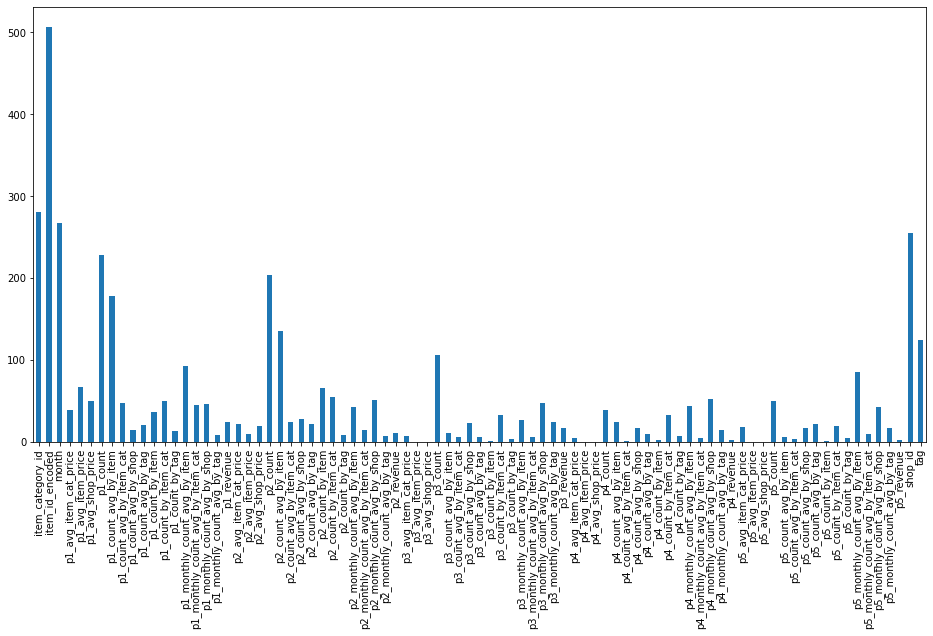

In [75]:

plot_feature_importance(lgb_model.feature_importances_, selected_cols)


### XGBoost

In [58]:
import xgboost as xgb

In [64]:


xgb_model = xgb.XGBRegressor(max_depth=8,
                              learning_rate=0.1,
                              n_estimators=16,
                              subsample=0.8,
                              verbosity=1,
                              random_state=42,
                              )
ignore_cols = ['shop_id_encoded', 'item_id', 'item_category_id_encoded', 'month_encoded', 'tag_encoded']
selected_cols = X_train.columns.difference(ignore_cols).tolist()

eval_indice = np.random.choice(len(X_train), len(X_val), replace=False,  )
xgb_model.fit(X_train[selected_cols], Y_train,
              eval_metric='rmse',
              eval_set=[(X_train.iloc[eval_indice][selected_cols], Y_train.iloc[eval_indice]), (X_val[selected_cols], Y_val)],
              verbose=True,
              early_stopping_rounds=30
              )


[02:44:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.01713	validation_1-rmse:1.00273
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:0.94654	validation_1-rmse:0.95057
[2]	validation_0-rmse:0.88418	validation_1-rmse:0.90381
[3]	validation_0-rmse:0.83040	validation_1-rmse:0.86380
[4]	validation_0-rmse:0.78395	validation_1-rmse:0.83015
[5]	validation_0-rmse:0.74231	validation_1-rmse:0.80069
[6]	validation_0-rmse:0.70666	validation_1-rmse:0.77675
[7]	validation_0-rmse:0.67500	validation_1-rmse:0.75591
[8]	validation_0-rmse:0.64850	validation_1-rmse:0.73790
[9]	validation_0-rmse:0.62546	validation_1-rmse:0.72131
[10]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=16, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='approx', validate_parameters=1, verbosity=1)

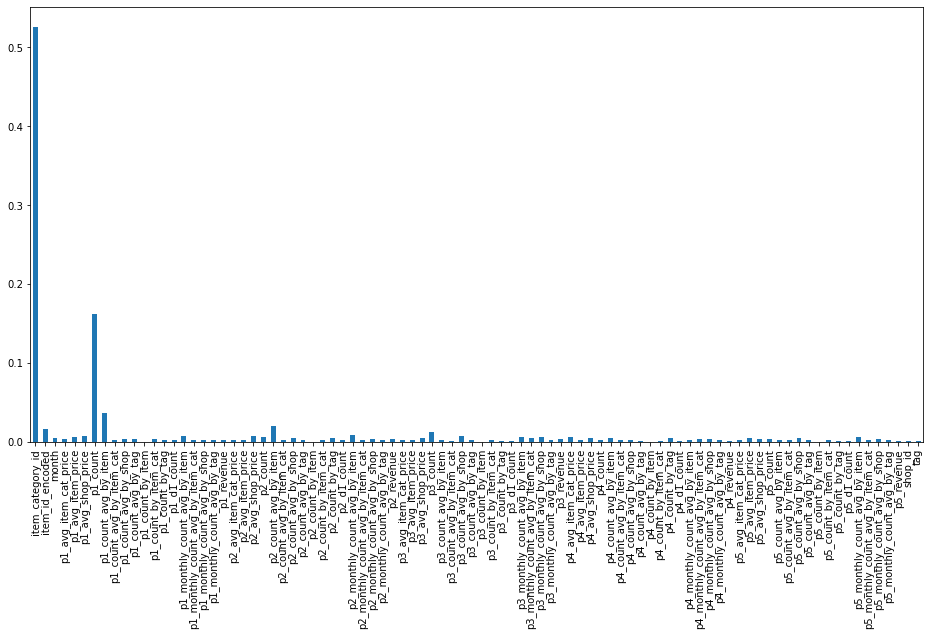

In [66]:

plot_feature_importance(xgb_model.feature_importances_, selected_cols)


### Recurrent Neural Network Model

In [72]:
import re
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Flatten
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor 


In [55]:
def to_timestep_shape(df):
    timeserie_cols = pd.Series(filter(re.compile('^p\d+\w+').match, df.columns))
    df = df[timeserie_cols]
    df.columns = pd.MultiIndex.from_tuples(timeserie_cols.str.split('_', 1).apply(tuple).tolist())
    df = df[df.columns.sortlevel(0, ascending=False )[0]]
    features = df.T.groupby(level=0).progress_apply(lambda feature: np.expand_dims(feature.T.values, axis=1)).to_numpy()
    features = features[::-1]
    X = np.concatenate(features, axis=1)
    return X

In [83]:
count_mean, count_var = scaler_params.loc['count'].tolist()

# def rmse_keras(y_true, y_pred):
#     batch_size = tf.shape(y_true)[0]

#     y_true = y_true*K.constant([count_var]*batch_size, dtype='float32') + K.constant([count_mean]*batch_size, dtype='float32')
#     y_pred = y_pred*K.constant([count_var]*batch_size, dtype='float32') + K.constant([count_mean]*batch_size, dtype='float32')
#     return RootMeanSquaredError(y_true, y_pred)

In [100]:
def build_lstm_model():
    model = Sequential([
        LSTM(32, activation='relu', return_sequences=False, input_shape=(len(lookback_steps), len(timeserie_cols))),
#         LSTM(16, activation='relu'),
        Flatten(),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()],)
    return model

In [101]:
model = build_lstm_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                6144      
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 6,177
Trainable params: 6,177
Non-trainable params: 0
_________________________________________________________________


In [102]:
model.fit(to_timestep_shape(X_train), Y_train,
          validation_data=(to_timestep_shape(X_val), Y_val),
          
          batch_size=256,
          epochs=16, )

100%|██████████| 5/5 [00:00<00:00, 16.47it/s]


Epoch 1/16
23429/23429 [==============================] - 71s 3ms/step - loss: 0.5380 - root_mean_squared_error: 0.7335 - val_loss: 0.6713 - val_root_mean_squared_error: 0.8193
Epoch 2/16
23429/23429 [==============================] - 72s 3ms/step - loss: 0.5158 - root_mean_squared_error: 0.7182 - val_loss: 0.6132 - val_root_mean_squared_error: 0.7831
Epoch 3/16
23429/23429 [==============================] - 72s 3ms/step - loss: 0.5049 - root_mean_squared_error: 0.7105 - val_loss: 0.6540 - val_root_mean_squared_error: 0.8087
Epoch 4/16
23429/23429 [==============================] - 72s 3ms/step - loss: 0.4970 - root_mean_squared_error: 0.7050 - val_loss: 0.6359 - val_root_mean_squared_error: 0.7974
Epoch 5/16
23429/23429 [==============================] - 72s 3ms/step - loss: 0.4907 - root_mean_squared_error: 0.7005 - val_loss: 0.6414 - val_root_mean_squared_error: 0.8009
Epoch 6/16
23429/23429 [==============================] - 72s 3ms/step - loss: 0.4856 - root_mean_squared_error: 0.

In [91]:
prediction = np.squeeze(model.predict(to_timestep_shape(X_val)))


100%|██████████| 5/5 [00:00<00:00, 14.50it/s]


In [92]:

result = pd.Series(evaluate(Y_val, prediction))
result

rmse    0.857037
r2      0.381610
dtype: float64

### Linear Regression

In [202]:
from sklearn.linear_model import LinearRegression

In [203]:
linear_model = LinearRegression(fit_intercept=False, n_jobs=8)
linear_model.fit(X_train, Y_train)

LinearRegression(fit_intercept=False, n_jobs=8)

In [204]:

prediction = linear_model.predict(X_val)

result = pd.Series(evaluate(Y_val, prediction))
result

rmse    0.738852
r2      0.540401
dtype: float64

In [56]:

prediction = linear_model.predict(X_val)

result = pd.Series(evaluate(Y_val, prediction))
result

rmse    0.739614
r2      0.539453
dtype: float64

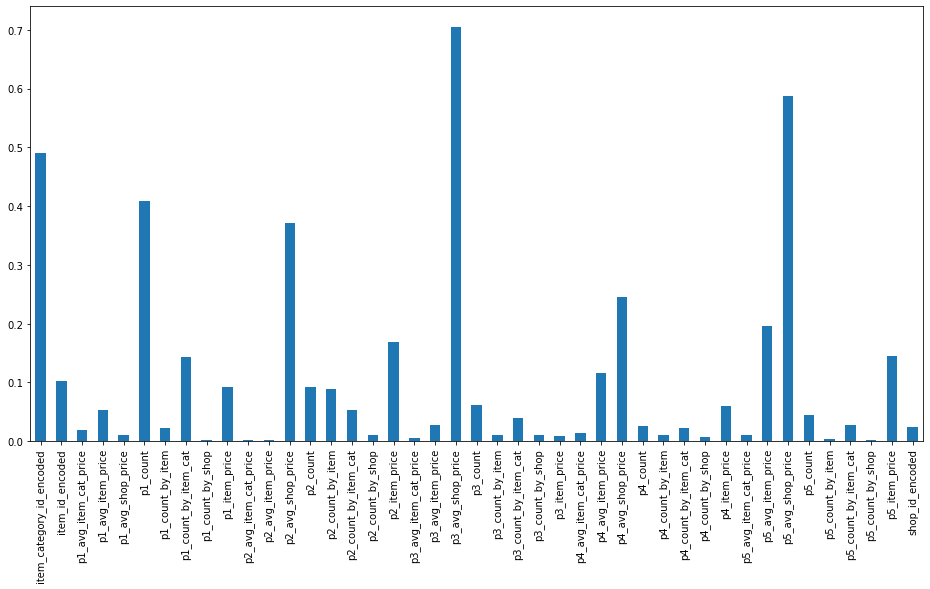

In [49]:
plot_feature_importance(np.abs(linear_model.coef_), X_train.columns)

<AxesSubplot:>

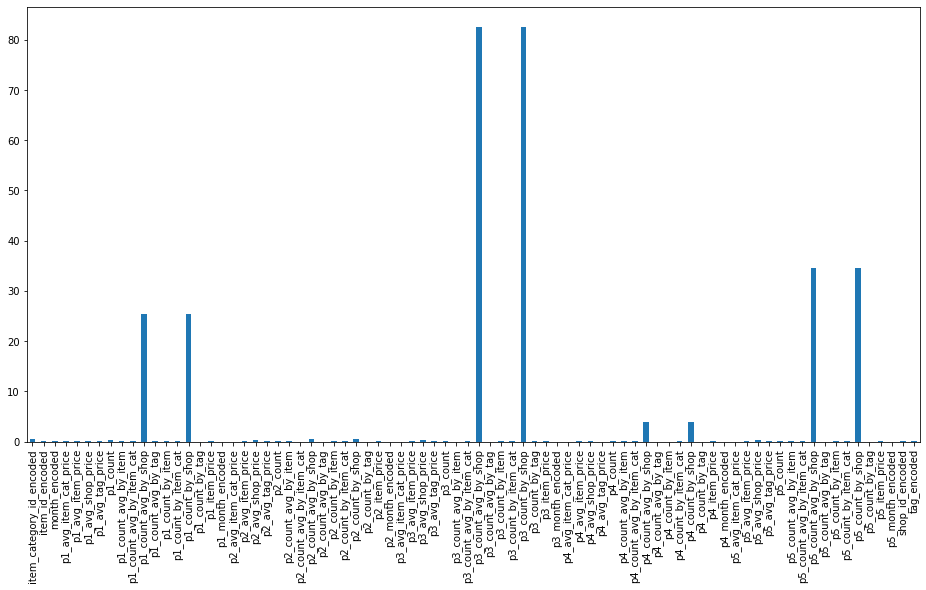

In [57]:
plot_feature_importance(np.abs(linear_model.coef_), X_train.columns)

### SVR

In [48]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

In [49]:
svr = SVR(kernel='linear' )
n_estimators = 24
bagging_svr = BaggingRegressor(svr,
                 n_estimators=n_estimators,
                 max_samples=0.1/n_estimators,
                 n_jobs=8,
                 verbose=1000,
                 random_state=43, )

In [ ]:

bagging_svr.fit(X_train, Y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


In [95]:

prediction = knn.predict(X_val)

result = pd.Series(evaluate(Y_val, prediction))
result

rmse    0.702860
r2      0.584088
dtype: float64

In [103]:
fitting_times = []
for n in tqdm(n_samples):
    t = time.time()
    svr.fit(X_train[:n], Y_train[:n])
    elapsed_time = time.time() - t
    fitting_times.append(elapsed_time)


  4%|▍         | 1/24 [00:00<00:04,  5.07it/s]

[LibSVM][LibSVM]

  8%|▊         | 2/24 [00:02<00:16,  1.33it/s]

[LibSVM]

 12%|█▎        | 3/24 [00:08<00:50,  2.39s/it]

[LibSVM]

 17%|█▋        | 4/24 [00:20<01:44,  5.23s/it]

[LibSVM]

 21%|██        | 5/24 [00:39<02:56,  9.27s/it]

[LibSVM]

 25%|██▌       | 6/24 [01:06<04:25, 14.73s/it]

[LibSVM]

 29%|██▉       | 7/24 [01:42<05:57, 21.02s/it]

[LibSVM]

 33%|███▎      | 8/24 [02:34<08:08, 30.54s/it]

[LibSVM]

 38%|███▊      | 9/24 [03:35<09:52, 39.47s/it]

[LibSVM]

 42%|████▏     | 10/24 [04:50<11:42, 50.18s/it]

[LibSVM]

 42%|████▏     | 10/24 [06:20<08:52, 38.00s/it]


KeyboardInterrupt: 

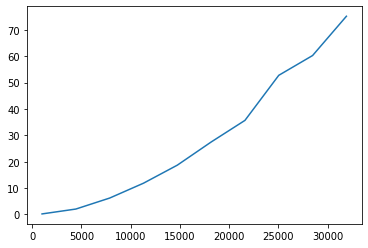

In [105]:
plt.plot(n_samples[:len(fitting_times)], fitting_times)

In [73]:
from sklearn.linear_model import LinearRegression

In [76]:
_model = LinearRegression()
_model.fit(np.expand_dims(n_samples**2, axis=1), np.array(fitting_times))

LinearRegression()

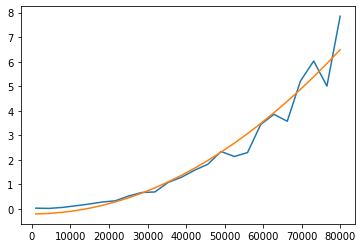

In [77]:
plt.plot(n_samples, fitting_times, label='actual')
plt.plot(n_samples, _model.predict(np.expand_dims(n_samples**2, axis=1)), label='prediction')

In [84]:
len(X_train)

5997600

In [87]:
_model.predict([[(len(X_train)*0.1)**2]]) / 60 / 60

array([0.10435984])

### Stacking

In [51]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.pipeline import Pipeline
import lightgbm as lgb

In [167]:
train_lgb_data = lgb.Dataset(X_train, label=Y_train, )
params = {
    'max_depth': 50,
    'learning_rate': 0.25,
    'num_leaves': 200,
    'n_estimators': 200,
    'bagging_fraction': 1/100,
    'sub_feature': 1,
    'metric': 'mse',
    'feature_fraction_seed': 41,
    'bagging_seed': 42
    
}
lgb_model = lgb.LGBMRegressor(**params, )

In [168]:
linear_model = LinearRegression(fit_intercept=False,
                                n_jobs=4)

In [169]:
rfr = RandomForestRegressor(n_estimators=100,
                            min_samples_split=2,
                            max_samples=0.5,
                            max_features=0.5,
                            max_depth=16,
                            n_jobs=4,
                            verbose=10
                           )

In [170]:
meta_model = RandomForestRegressor(max_depth=8,
                                   n_estimators=32,
                                   n_jobs=-1, 
                                   random_state=213)
stack_regressor = StackingRegressor([('rfr', rfr),
                                     ('lgb', lgb_model),
                                     ('linear', linear_model)
                                     ],
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=3,
                                    verbose=100,

                                    )

In [171]:
stack_regressor.fit(X_train, Y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   32.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   55.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  5.1min finished


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=1. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.01, subsample=1.0 will be ignored. Current value: bagging_fraction=0.01
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   34.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   47.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   31.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   42.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.5min remaining:    0.0s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   36.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   49.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.2s remaining:    0.0s
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=1. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.01, subsample=1.0 will be ignored. Current value: bagging_fraction=0.01
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.1s remaining:    0.0s
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=1. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.01, subsample=1.0 will be ignored. Current value: bagging_fraction=0.01
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Para

StackingRegressor(cv=3,
                  estimators=[('rfr',
                               RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=16,
                                                     max_features=0.5,
                                                     max_leaf_nodes=None,
                                                     max_samples=0.5,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estima

In [172]:
prediction = np.squeeze(stack_regressor.predict(X_val))

result = pd.Series(evaluate(Y_val, prediction))
result

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


rmse    0.588264
r2      0.722053
dtype: float64

## Predict

In [76]:
ignore_cols = ['shop_id_encoded', 'item_id', 'item_category_id_encoded', 'month_encoded', 'tag_encoded']
selected_cols = X_test.columns.difference(ignore_cols).tolist()
model = lgb_model
prediction = model.predict(X_test[selected_cols].to_numpy())




In [77]:
submission_df = pd.DataFrame(np.array([test_data['ID'].values, prediction]).T,
                             columns=['ID', 'item_cnt_month'], )
submission_df['ID'] = submission_df['ID'].astype(int)
submission_df 

,ID,item_cnt_month
0,0,0.155848
1,1,0.077701
2,2,1.059933
3,3,0.114903
4,4,0.077701
...,...,...
214195,214195,0.757282
214196,214196,0.077701
214197,214197,0.083858
214198,214198,0.077701


In [78]:
submission_df['item_cnt_month'].describe()

count    214200.000000
mean          0.237096
std           0.496983
min           0.075142
25%           0.077701
50%           0.082741
75%           0.103654
max          12.521695
Name: item_cnt_month, dtype: float64

In [79]:
submission_df.to_csv('submission/outputv38.csv', index=False)